[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marharyta-aleksandrova/conformal-learning/blob/main/tutorials/Exercise_2._Impact_of_nonconformity_functions_classification.ipynb)

Installing `nonconformist` library (uncomment the cells below)

In [1]:
# !git clone https://github.com/donlnz/nonconformist

In [2]:
# cd nonconformist

In [3]:
# !python setup.py install

In [3]:
pip install pandas==1.5.3

# Imports

In [4]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import load_iris

from nonconformist.base import ClassifierAdapter
from nonconformist.icp import IcpClassifier
from nonconformist.nc import MarginErrFunc, InverseProbabilityErrFunc
from nonconformist.nc import ClassifierNc
from nonconformist.nc import NcFactory

from nonconformist.evaluation import cross_val_score
from nonconformist.evaluation import ClassIcpCvHelper
from nonconformist.evaluation import class_avg_c, class_mean_errors, class_one_c, class_one_err, \
    class_mean_errors_one_class, class_one_err_one_class, class_mean_p_val, class_empty, n_test

import random
import matplotlib.pyplot as plt

import pandas as pd

# Iris data

## Margin vs IP

Loading data

In [5]:
data = load_iris()

Inverse Probability

In [6]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100),
                                                   #KNeighborsClassifier(n_neighbors=10),
                                                   #AdaBoostClassifier(),
                                                  ), 
                                 err_func=InverseProbabilityErrFunc()), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=5,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('InverseProbabilityErrFunc')

scores = scores.drop(['fold', 'iter'], axis=1)
scores_ip = scores.groupby(['significance']).mean()
scores_ip

iter 5/5 fold 5/5InverseProbabilityErrFunc


,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.033333,1.176000,0.850667,0.009333
0.10,0.101333,0.917333,0.906667,0.088000
0.20,0.185333,0.821333,0.821333,0.178667


Margin

In [7]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100),
                                                   #KNeighborsClassifier(n_neighbors=10),
                                                   #AdaBoostClassifier(),
                                                  ), 
                                 err_func=MarginErrFunc()), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=5,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('MarginErrFunc')

scores = scores.drop(['fold', 'iter'], axis=1)
scores_m = scores.groupby(['significance']).mean()
scores_m

iter 5/5 fold 5/5MarginErrFunc


,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.033333,1.221333,0.852000,0.009333
0.10,0.101333,0.920000,0.908000,0.086667
0.20,0.185333,0.821333,0.821333,0.178667


### Analysing validity

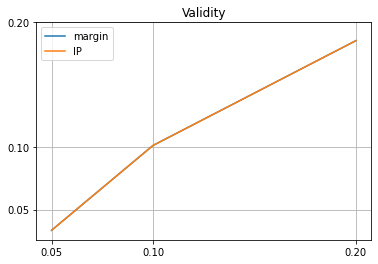

In [8]:
plt.plot(scores_m.index, scores_m['class_mean_errors'])
plt.plot(scores_ip.index, scores_ip['class_mean_errors'], )
plt.grid(True)
plt.xticks(scores_m.index)
plt.yticks(scores_m.index)
plt.title('Validity')
plt.legend(['margin', 'IP'])
plt.show()

### $avgC$

In [9]:
col = 'class_avg_c'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
})
print(col)
tmp

class_avg_c


,margin,IP
significance,,
0.05,1.221333,1.176000
0.10,0.920000,0.917333
0.20,0.821333,0.821333


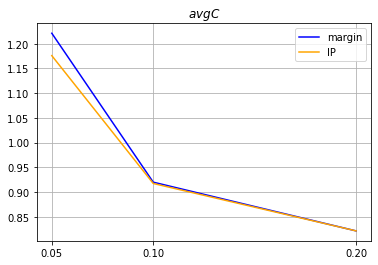

In [10]:
plt.plot(scores_m.index, scores_m['class_avg_c'], c='b')
plt.plot(scores_ip.index, scores_ip['class_avg_c'], c='orange')
plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$avgC$')
plt.legend(['margin', 'IP'])
plt.show()

### $oneC$, $zeroC$

In [11]:
col = 'class_one_c'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
})
print(col)
tmp

class_one_c


,margin,IP
significance,,
0.05,0.852000,0.850667
0.10,0.908000,0.906667
0.20,0.821333,0.821333


In [12]:
col = 'class_empty'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
})
print(col)
tmp

class_empty


,margin,IP
significance,,
0.05,0.009333,0.009333
0.10,0.086667,0.088000
0.20,0.178667,0.178667


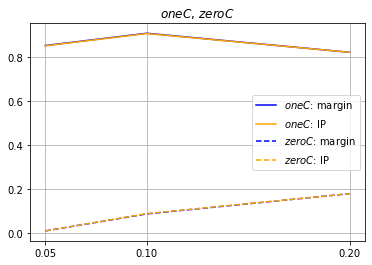

In [13]:
plt.plot(scores_m.index, scores_m['class_one_c'], c='b')
plt.plot(scores_ip.index, scores_ip['class_one_c'], c='orange')

plt.plot(scores_m.index, scores_m['class_empty'], '--', c='b',)
plt.plot(scores_ip.index, scores_ip['class_empty'], '--', c='orange')

plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$oneC$, $zeroC$')
plt.legend(['$oneC$: margin', '$oneC$: IP', '$zeroC$: margin', '$zeroC$: IP'])
plt.show()

## Creating new nonconformity functions

Here, we introduce a nonconformity function for classification, where

$\alpha_i = \sum_{y \, \neq \, y_i} \hat{P}\left(y \mid x_i \right) ^ 2$

In [14]:
from nonconformist.nc import ClassificationErrFunc

class MyClassErrFunc(ClassificationErrFunc):
    def __init__(self):
        super(MyClassErrFunc, self).__init__()
        
    def apply(self, prediction, y):
        '''
            y is a vector of labels
            prediction is a matrix of class probability estimates
        '''
        prob = np.zeros(y.size, dtype=np.float32)
        for i, y_ in enumerate(y):
            if y_ >= prediction.shape[1]:
                prob[i] = 0
            else:
                prob[i] = (prediction[i, :] ** 2).sum()
                prob[i] -= prediction[i, int(y_)] ** 2
        return prob


In [15]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100),
                                                   #KNeighborsClassifier(n_neighbors=10),
                                                   #AdaBoostClassifier(),
                                                  ), 
                                 err_func=MyClassErrFunc()), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=5,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('myFunc')

scores = scores.drop(['fold', 'iter'], axis=1)
scores_myFunc = scores.groupby(['significance']).mean()
scores_myFunc

iter 5/5 fold 5/5myFunc


,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.032000,1.250667,0.850667,0.009333
0.10,0.101333,0.921333,0.908000,0.086667
0.20,0.185333,0.821333,0.821333,0.178667


### Validity

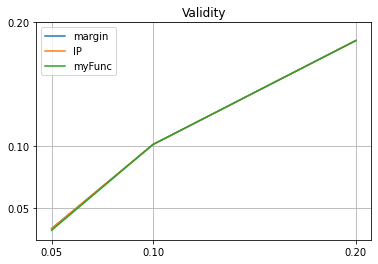

In [16]:
plt.plot(scores_m.index, scores_m['class_mean_errors'])
plt.plot(scores_ip.index, scores_ip['class_mean_errors'], )
plt.plot(scores_ip.index, scores_myFunc['class_mean_errors'], )
plt.grid(True)
plt.xticks(scores_m.index)
plt.yticks(scores_m.index)
plt.title('Validity')
plt.legend(['margin', 'IP', 'myFunc'])
plt.show()

### $avgC$

In [17]:
col = 'class_avg_c'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
    'myFunc': scores_myFunc[col]
})
print(col)
tmp

class_avg_c


,margin,IP,myFunc
significance,,,
0.05,1.221333,1.176000,1.250667
0.10,0.920000,0.917333,0.921333
0.20,0.821333,0.821333,0.821333


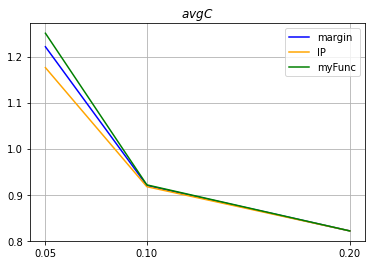

In [18]:
plt.plot(scores_m.index, scores_m['class_avg_c'], c='b')
plt.plot(scores_ip.index, scores_ip['class_avg_c'], c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_avg_c'], c='green')
plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$avgC$')
plt.legend(['margin', 'IP', 'myFunc'])
plt.show()

### $oneC$, $zeroC$

In [19]:
col = 'class_one_c'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
    'myFunc': scores_myFunc[col],
})
print(col)
tmp

class_one_c


,margin,IP,myFunc
significance,,,
0.05,0.852000,0.850667,0.850667
0.10,0.908000,0.906667,0.908000
0.20,0.821333,0.821333,0.821333


In [20]:
col = 'class_empty'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
    'myFunc': scores_myFunc[col],
})
print(col)
tmp

class_empty


,margin,IP,myFunc
significance,,,
0.05,0.009333,0.009333,0.009333
0.10,0.086667,0.088000,0.086667
0.20,0.178667,0.178667,0.178667


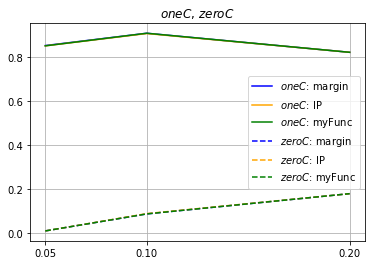

In [21]:
plt.plot(scores_m.index, scores_m['class_one_c'], c='b')
plt.plot(scores_ip.index, scores_ip['class_one_c'], c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_one_c'], c='green')

plt.plot(scores_m.index, scores_m['class_empty'], '--', c='b',)
plt.plot(scores_ip.index, scores_ip['class_empty'], '--', c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_empty'], '--', c='green')

plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$oneC$, $zeroC$')
plt.legend(['$oneC$: margin', '$oneC$: IP', '$oneC$: myFunc',
            '$zeroC$: margin', '$zeroC$: IP', '$zeroC$: myFunc',
            
           ])
plt.show()

# Synthetic dataset

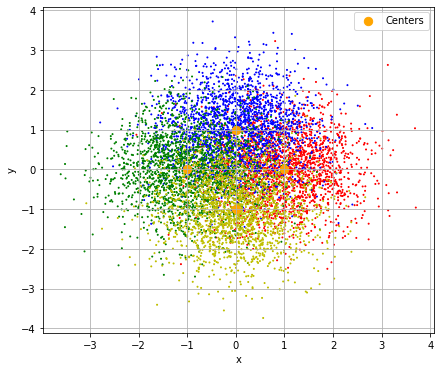

In [22]:
import pandas as pd

np.random.seed(20)
# centers of 4 classes
centers = [
    [ 1,  0],
    [ 0,  1],
    [-1,  0],
    [ 0, -1],
]

# colors to plot members of different classes
color_arr = ['r', 'b', 'g', 'y']

# number of instances per class
n_points = 2000
# these arrays will store information about datapoints
data_x = []
data_y = []
data_class = []
data_color = []

# standard deviation to generate the class instances
sigma = 0.8
# data generation
for class_val in range(0, len(centers)):
    x, y = centers[class_val]
    data_class.extend([class_val for j in range(0, n_points)])
    data_color.extend([color_arr[class_val] for j in range(0, n_points)])
    data_x.extend(np.random.normal(x, sigma, size=n_points))
    data_y.extend(np.random.normal(y, sigma, size=n_points))
# putting everything into a dataframe
data_df = pd.DataFrame({
    'x': data_x,
    'y': data_y,
    'class': data_class,
    'color': data_color,
})
# plotting the dataset
data_df.plot(
    kind='scatter',
    x='x',
    y='y',
    c=data_df['color'],
    s=1,
    grid=True,
    figsize=(7,6),
)

data = {'data': data_df[['x', 'y']].values, 'target': data_df['class'].values}

# showing the centers in orange
plt.scatter(np.array(centers).T[0], np.array(centers).T[1], s=70, c='orange', label='Centers')
plt.legend()
plt.show()

In [23]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100),
                                                   #SVC(probability=True),
                                                  ), 
                                 err_func=InverseProbabilityErrFunc()), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=5,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('InverseProbabilityErrFunc')

scores = scores.drop(['fold', 'iter'], axis=1)
scores_ip = scores.groupby(['significance']).mean()
scores_ip

iter 5/5 fold 5/5InverseProbabilityErrFunc


,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.042875,2.727250,0.067000,0.0
0.10,0.093275,2.215025,0.185825,0.0
0.20,0.194775,1.628775,0.444200,0.0


In [24]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100),
                                                   #SVC(probability=True),
                                                  ), 
                                 err_func=MarginErrFunc()), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=5,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('MarginErrFunc')

scores = scores.drop(['fold', 'iter'], axis=1)
scores_m = scores.groupby(['significance']).mean()
scores_m

iter 5/5 fold 5/5MarginErrFunc


,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.048075,3.074150,0.229250,0.0
0.10,0.098425,2.498400,0.361800,0.0
0.20,0.197725,1.683875,0.566725,0.0


In [25]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100),
                                                   #SVC(probability=True)
                                                  ), 
                                 err_func=MyClassErrFunc()), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=5,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('myFunc')

scores = scores.drop(['fold', 'iter'], axis=1)
scores_myFunc = scores.groupby(['significance']).mean()
scores_myFunc

iter 5/5 fold 5/5myFunc


,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.047825,3.189400,0.26280,0.0
0.10,0.098825,2.670325,0.41005,0.0
0.20,0.197500,1.769050,0.61275,0.0


### Validity

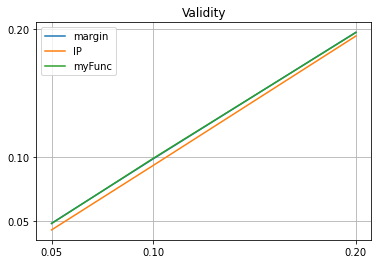

In [26]:
plt.plot(scores_m.index, scores_m['class_mean_errors'])
plt.plot(scores_ip.index, scores_ip['class_mean_errors'], )
plt.plot(scores_ip.index, scores_myFunc['class_mean_errors'], )
plt.grid(True)
plt.xticks(scores_m.index)
plt.yticks(scores_m.index)
plt.title('Validity')
plt.legend(['margin', 'IP', 'myFunc'])
plt.show()

### $avgC$

In [27]:
col = 'class_avg_c'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
    'myFunc': scores_myFunc[col]
})
print(col)
tmp

class_avg_c


,margin,IP,myFunc
significance,,,
0.05,3.074150,2.727250,3.189400
0.10,2.498400,2.215025,2.670325
0.20,1.683875,1.628775,1.769050


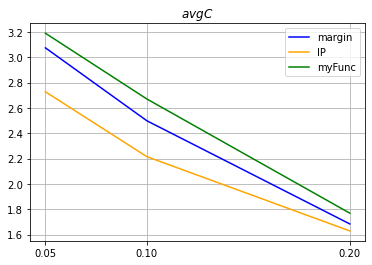

In [28]:
plt.plot(scores_m.index, scores_m['class_avg_c'], c='b')
plt.plot(scores_ip.index, scores_ip['class_avg_c'], c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_avg_c'], c='green')
plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$avgC$')
plt.legend(['margin', 'IP', 'myFunc'])
plt.show()

### $oneC$, $zeroC$

In [29]:
col = 'class_one_c'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
    'myFunc': scores_myFunc[col],
})
print(col)
tmp

class_one_c


,margin,IP,myFunc
significance,,,
0.05,0.229250,0.067000,0.26280
0.10,0.361800,0.185825,0.41005
0.20,0.566725,0.444200,0.61275


In [30]:
col = 'class_empty'
tmp = pd.DataFrame({
    'margin': scores_m[col],
    'IP': scores_ip[col],
    'myFunc': scores_myFunc[col],
})
print(col)
tmp

class_empty


,margin,IP,myFunc
significance,,,
0.05,0.0,0.0,0.0
0.10,0.0,0.0,0.0
0.20,0.0,0.0,0.0


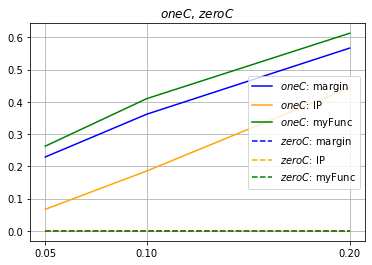

In [31]:
plt.plot(scores_m.index, scores_m['class_one_c'], c='b')
plt.plot(scores_ip.index, scores_ip['class_one_c'], c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_one_c'], c='green')

plt.plot(scores_m.index, scores_m['class_empty'], '--', c='b',)
plt.plot(scores_ip.index, scores_ip['class_empty'], '--', c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_empty'], '--', c='green')

plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$oneC$, $zeroC$')
plt.legend(['$oneC$: margin', '$oneC$: IP', '$oneC$: myFunc',
            '$zeroC$: margin', '$zeroC$: IP', '$zeroC$: myFunc',
            
           ])
plt.show()

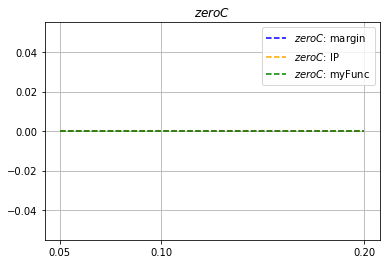

In [32]:
plt.plot(scores_m.index, scores_m['class_empty'], '--', c='b',)
plt.plot(scores_ip.index, scores_ip['class_empty'], '--', c='orange')
plt.plot(scores_ip.index, scores_myFunc['class_empty'], '--', c='green')

plt.grid(True)
plt.xticks(scores_m.index)
plt.title('$zeroC$')
plt.legend([#'$oneC$: margin', '$oneC$: IP', '$oneC$: myFunc',
            '$zeroC$: margin', '$zeroC$: IP', '$zeroC$: myFunc',
            
           ])
plt.show()

Try with other models:

1. `KNeighborsClassifier(n_neighbors=10)`
2. `AdaBoostClassifier()`

Try with another dataset (any dataset, for example, from the [UCI ML repository](https://archive.ics.uci.edu/ml/index.php))